In [1]:
import os
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import isingmodellight
from isingmodellight import IsingModelLight
from scipy import stats
import time
import hcpdatautils as hcp

int_type = torch.int
float_type = torch.float
device = torch.device('cuda')

file_dir = 'E:\\Ising_model_results_daai'

training_index_start = 0
training_index_end = 670

In [2]:
def depytorch(t:torch.Tensor):
    return t.detach().cpu().numpy()

In [3]:
def show_square(values:torch.Tensor, width:int=10, height:int=10):
    fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(width, height) )
    cbax = axs.imshow( depytorch(values) )
    fig.colorbar(cbax, shrink=0.8)

In [21]:
def print_stats(name:str, values:torch.Tensor):
    values = values.flatten()
    quantile_cutoffs = torch.tensor([0.025, 0.5, 0.975], dtype=float_type, device=device)
    quantiles = torch.quantile(values, quantile_cutoffs)
    min_val = torch.min(values)
    max_val = torch.max(values)
    print(f'The distribution of {name} values has median {quantiles[1].item():.3g} with 95% CI [{quantiles[0].item():.3g}, {quantiles[2].item():.3g}] and range [{min_val.item():.3g}, {max_val.item():.3g}].')

In [20]:
def make_histogram(name:str, values:torch.Tensor):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    axs.hist(  depytorch( values.flatten() )  )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(name)
    axs.set_ylabel('count in bin')
    axs.set_title(f'distribution of {name}')
    plt.show()

In [25]:
def make_scatter(xname:str, xvalues:torch.Tensor, yname:str, yvalues:torch.Tensor, do_log_log:bool=False, save:bool=False, file_name:str=None):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    axs.scatter(  depytorch( xvalues.flatten() ), depytorch( yvalues.flatten() )  )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    if do_log_log:
        axs.set_xscale('log')
        axs.set_yscale('log')
    axs.set_xlabel(xname)
    axs.set_ylabel(yname)
    # axs.set_title(f'{xname} vs {yname}')
    plt.show()
    if save:
        plt.savefig(file_name)

In [4]:
data_file_fragment = 'mean_std_1'

In [5]:
data_states_file = os.path.join(file_dir, f'data_states_{data_file_fragment}.pt')
data_states = torch.load(data_states_file)
print( data_states.size() )

torch.Size([3216000, 360])


In [6]:
is_non0 = torch.any(data_states, dim=-1)
non0_indices = torch.nonzero(is_non0)
print( non0_indices.numel() )

2844544


In [7]:
print( non0_indices[:10].flatten(), non0_indices[-10:].flatten() )

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0') tensor([2844535, 2844536, 2844537, 2844538, 2844539, 2844540, 2844541, 2844542,
        2844543, 2844544], device='cuda:0')


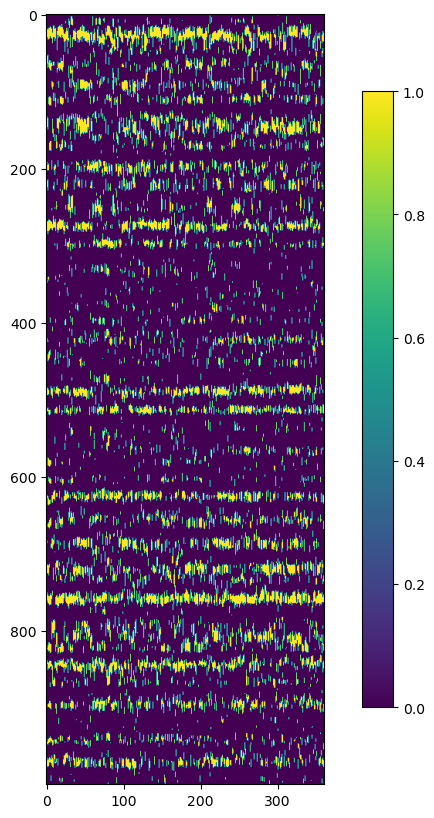

In [8]:
show_square(data_states[:1000,:])

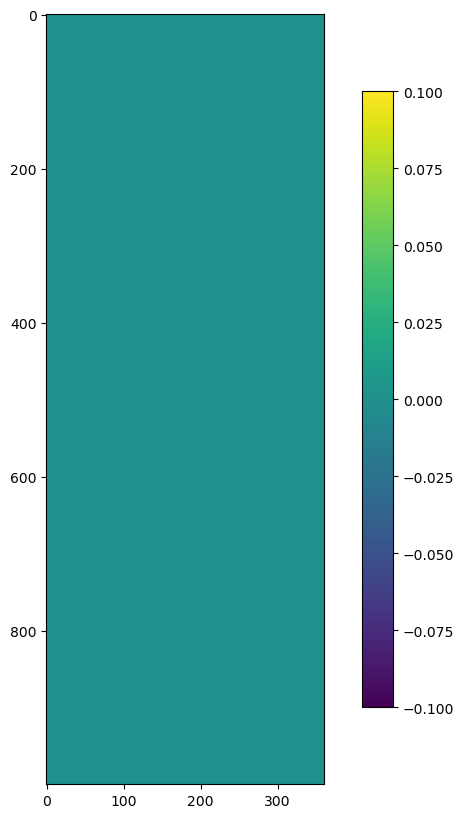

In [9]:
show_square(data_states[-1000:,:])

In [10]:
last_state_index = non0_indices.flatten()[-1]
data_states = data_states[:(last_state_index+1),:]
print( data_states.size() )

torch.Size([2844545, 360])


In [12]:
torch.save( obj=data_states.clone(), f=data_states_file )

In [13]:
group_data_counts_file = os.path.join(file_dir, f'group_data_counts_{data_file_fragment}.pt')
group_data_counts = torch.load(group_data_counts_file)
print( group_data_counts.size() )

torch.Size([3216000])


In [16]:
is_non0 = group_data_counts > 0
non0_indices = torch.nonzero(is_non0).flatten()
print( non0_indices.numel() )
print( non0_indices[:10], non0_indices[-10:] )

2844545
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0') tensor([2844535, 2844536, 2844537, 2844538, 2844539, 2844540, 2844541, 2844542,
        2844543, 2844544], device='cuda:0')


In [17]:
group_data_counts = group_data_counts[is_non0]
print( group_data_counts.size() )

torch.Size([2844545])


In [18]:
torch.save( obj=group_data_counts.clone(), f=group_data_counts_file )

The distribution of count of unique state values has median 1 with 95% CI [1, 1] and range [1, 1.36e+05].


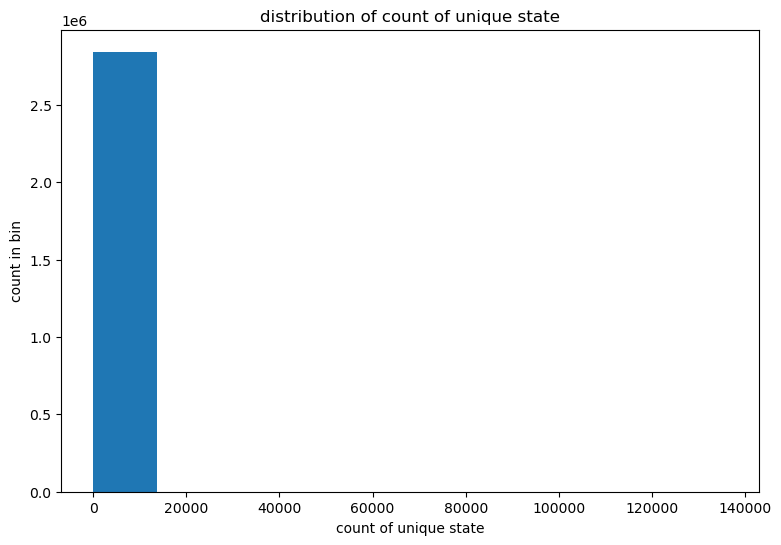

In [23]:
name='count of unique state'
values=group_data_counts.float()
print_stats(name=name, values=values)
make_histogram(name=name, values=values)

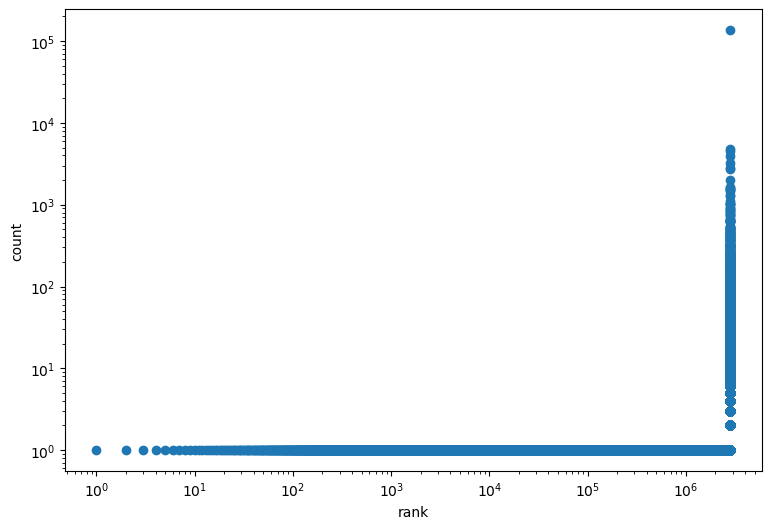

In [28]:
group_data_counts = torch.sort(group_data_counts).values.float()
count_ranks = torch.arange( start=0, end=group_data_counts.numel(), dtype=group_data_counts.dtype, device=group_data_counts.device )
make_scatter(xname='rank', xvalues=count_ranks, yname='count', yvalues=group_data_counts, do_log_log=True)

In [19]:
individual_data_counts_file = os.path.join(file_dir, f'individual_data_counts_{data_file_fragment}.pt')
individual_data_counts = torch.load(individual_data_counts_file)
print( individual_data_counts.size() )

torch.Size([4, 670, 360])
